In [98]:
import numpy as np
import matplotlib .pyplot as plt
from scipy.stats import multivariate_normal as smn
#from jax.scipy.stats import multivariate_normal as jmn
#from jax import random
import scipy

import jax.numpy as jnp

In [103]:
def RBF(t,tau):
    Dt = t - np.array([t]).T
    K=np.exp(-(Dt)**2/2/(tau**2))
    #deltaXsq = jnp.power((t[:, None] - t) /tau, 2.0)
    #K = jnp.exp(-0.5 * deltaXsq)
    return K

def Matern32(t,tau):
    Dt = t - np.array([t]).T
    fac=np.sqrt(3.0)*np.abs(Dt)/tau
    K=(1.0+fac)*np.exp(-fac)
    return K

In [126]:
np.random.seed(seed=1)
N = 31
t = np.linspace(0,10,N)
ave = np.zeros(N)
tau = 1.5

ave = jnp.zeros(N)
cov = RBF(t,tau)
#cov = Matern32(t,tau)
d = smn(mean=ave ,cov=cov , allow_singular =True).rvs(1).T
#key = random.PRNGKey(4)
#d=jmn(ave,cov,allow_singular =True).rvs(1).T


sigma=0.3
d=d+np.random.normal(0.0,sigma,len(d))

Text(0.5, 0, 't')

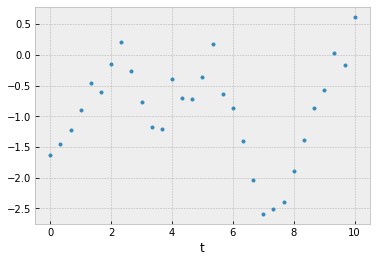

In [127]:
import seaborn as sns
plt.style.use('bmh')
plt.plot(t,d,".")
plt.xlabel("t")

In [128]:
def muGP(tau,sigma):
    cov = RBF(t,tau)
    Pid=np.eye(N)/sigma**2
    IKw=np.eye(N)+Pid@cov
    A=scipy.linalg.solve(IKw,Pid@d,assume_a="pos")
    return cov@A

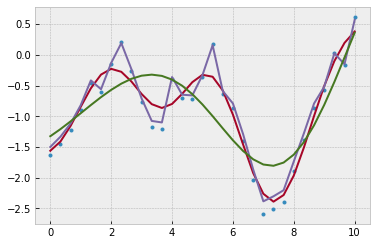

In [129]:



#cov@Pid@d
plt.plot(t,d,".")
plt.plot(t,muGP(1.5,sigma))
plt.plot(t,muGP(0.1,sigma))
plt.plot(t,muGP(3.,sigma))

In [130]:
def jRBF(t,tau):
    Dt = t - jnp.array([t]).T
    K=jnp.exp(-(Dt)**2/2/(tau**2))
    #deltaXsq = jnp.power((t[:, None] - t) /tau, 2.0)
    #K = jnp.exp(-0.5 * deltaXsq)
    return K

In [131]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

def model(t,y):
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    tau = numpyro.sample('tau', dist.Exponential(1.))
    cov = jRBF(t,tau)
    Pid=jnp.eye(N)/sigma**2
    IKw=jnp.eye(N)+Pid@cov
    A=jnp.linalg.solve(IKw,Pid@y)
    mu=cov@A
    K=cov@IKw
    numpyro.sample('y', dist.MultivariateNormal(loc=mu, covariance_matrix=K), obs=y)

In [133]:
from numpyro.infer import MCMC, NUTS

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000
# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, t=t, y=d)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:27<00:00, 109.91it/s, 7 steps of size 5.25e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      2.01      0.64      1.89      1.10      2.90   1165.95      1.00
       tau      0.35      0.02      0.36      0.32      0.39    859.61      1.00

Number of divergences: 0


In [136]:
import arviz
arviz.plot_trace(mcmc, var_names=["tau","sigma"])
#plt.savefig("gp1.pdf")

ModuleNotFoundError: No module named 'netCDF4'